In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor

## Setup

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device} ")

Using device: cuda 


In [4]:
print("Current Cuda Device: {}".format(torch.cuda.current_device()))
print("Device 0 name: {}".format(torch.cuda.get_device_name(0)))

Current Cuda Device: 0
Device 0 name: NVIDIA GeForce GTX 1060


In [37]:
# Default PyTorch dataset framework; img_dir must be specified and csv rows must be formatted as: filename,label
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [17]:
# Define general NN model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)
        self.linear = nn.Linear(21632, 500)
        self.linear2 = nn.Linear(500, 10)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()
#         self.stack = nn.Sequential(
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.relu(x)
        logits = self.linear2(x)
        return logits

In [18]:
# model = NeuralNetwork()

In [ ]:
# Per PyTorch: All pre-trained models expect input images normalized in the same way:
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224
# The images have to be loaded in to a range of [0, 1] and then normalized using
# mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [28]:
# If using residual net pretrained on ImageNet data
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

Using cache found in C:\Users\thoma/.cache\torch\hub\pytorch_vision_v0.10.0


In [29]:
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.005)

In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        
        # Preprocessing needed for pretrained models like ResNet
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
        
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Testing on Public MNIST Dataset

In [23]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

In [24]:
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [25]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


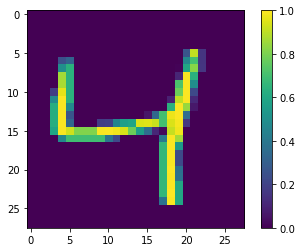

Ground truth: 4


In [26]:
# Sample visualization
n = 2  # slice
plt.imshow(X[n][0], interpolation='nearest')
plt.colorbar()
plt.show()
print("Ground truth: {}".format(y[n]))

In [27]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303921  [    0/60000]
loss: 0.242171  [ 6400/60000]
loss: 0.143744  [12800/60000]
loss: 0.140093  [19200/60000]
loss: 0.079750  [25600/60000]
loss: 0.170518  [32000/60000]
loss: 0.202803  [38400/60000]
loss: 0.204086  [44800/60000]
loss: 0.306435  [51200/60000]
loss: 0.076393  [57600/60000]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.103248 

Epoch 2
-------------------------------
loss: 0.090938  [    0/60000]
loss: 0.094877  [ 6400/60000]
loss: 0.042177  [12800/60000]
loss: 0.102859  [19200/60000]
loss: 0.028173  [25600/60000]
loss: 0.041681  [32000/60000]
loss: 0.079733  [38400/60000]
loss: 0.081660  [44800/60000]
loss: 0.191324  [51200/60000]
loss: 0.055518  [57600/60000]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.094891 

Epoch 3
-------------------------------
loss: 0.098737  [    0/60000]
loss: 0.013506  [ 6400/60000]
loss: 0.025344  [12800/60000]
loss: 0.124207  [19200/60000]
loss: 0.055090  [25600/60000]
loss: 0.050356  [32000/600